(mmm_multidimensional_example)=
# MMM Multidimensional Example Notebook

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor
from pymc.model.transform.optimization import freeze_dims_and_data

from pymc_marketing.mmm import GeometricAdstock, MichaelisMentenSaturation
from pymc_marketing.mmm.multidimensional import MMM
from pymc_marketing.prior import Prior

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [13, 15]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 8

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

/Users/juanitorduz/Documents/pymc-marketing/pymc_marketing/mmm/multidimensional.py:55: FutureWarning: This functionality is experimental and subject to change. If you encounter any issues or have suggestions, please raise them at: https://github.com/pymc-labs/pymc-marketing/issues/new
  warnings.warn(warning_msg, FutureWarning, stacklevel=1)


In [33]:
# Generate a date range
date_range = pd.date_range(start="2023-01-01", end="2023-01-30")

# Define countries and channels
countries = ["Venezuela", "Colombia", "Chile", "Argentina"]
channels = ["a", "b"]
n_channels = len(channels)

# Set random seed
rng = np.random.default_rng(42)

# Create a DataFrame
data = []
for country in countries:
    for date in date_range:
        record = [date, country, *list(rng.integers(100, 500, size=n_channels))]
        data.append(record)

df = pd.DataFrame(data, columns=["date", "country", *channels])
df["target"] = df[channels].sum(axis=1) + 10 * rng.normal(size=len(df)) + 60

df.head()

,date,country,a,b,target
0,2023-01-01,Venezuela,135,409,620.017789
1,2023-01-02,Venezuela,361,275,693.606444
2,2023-01-03,Venezuela,273,443,765.765025
3,2023-01-04,Venezuela,134,378,573.792756
4,2023-01-05,Venezuela,180,137,379.199967


In [34]:
# split df in train and test
train_test_split = pd.to_datetime("2023-01-15")
df_train = df.query("date < @train_test_split")
df_test = df.query("date >= @train_test_split")

In [35]:
hierarchical_alpha_saturation = Prior(
    "Gamma",
    mu=Prior("HalfNormal", sigma=1, dims="country"),
    sigma=Prior("HalfNormal", sigma=1, dims="country"),
    dims=("channel", "country"),
)

common_lam_saturation = Prior("HalfNormal", sigma=1, dims=("channel",))

priors: dict[str, Prior] = {
    "alpha": hierarchical_alpha_saturation,
    "lam": common_lam_saturation,
}

saturation = MichaelisMentenSaturation(priors=priors)

In [36]:
saturation.model_config

{'saturation_alpha': Prior("Gamma", mu=Prior("HalfNormal", sigma=1, dims="country"), sigma=Prior("HalfNormal", sigma=1, dims="country"), dims=("channel", "country")),
 'saturation_lam': Prior("HalfNormal", sigma=1, dims="channel")}

In [37]:
alpha = Prior("HalfNormal", sigma=1, dims="channel")
adstock = GeometricAdstock(l_max=2)
adstock.model_config

{'adstock_alpha': Prior("Beta", alpha=1, beta=3)}

In [38]:
mmm = MMM(
    date_column="date",
    target_column="target",
    channel_columns=["a", "b"],
    dims=("country",),
    adstock=adstock,
    saturation=saturation,
    yearly_seasonality=12,
    time_varying_media=True,
    time_varying_intercept=True,
)

In [39]:
mmm.build_model(
    X=df_train.drop(columns="target"),
    y=df_train.set_index(["date", "country"])["target"],
)

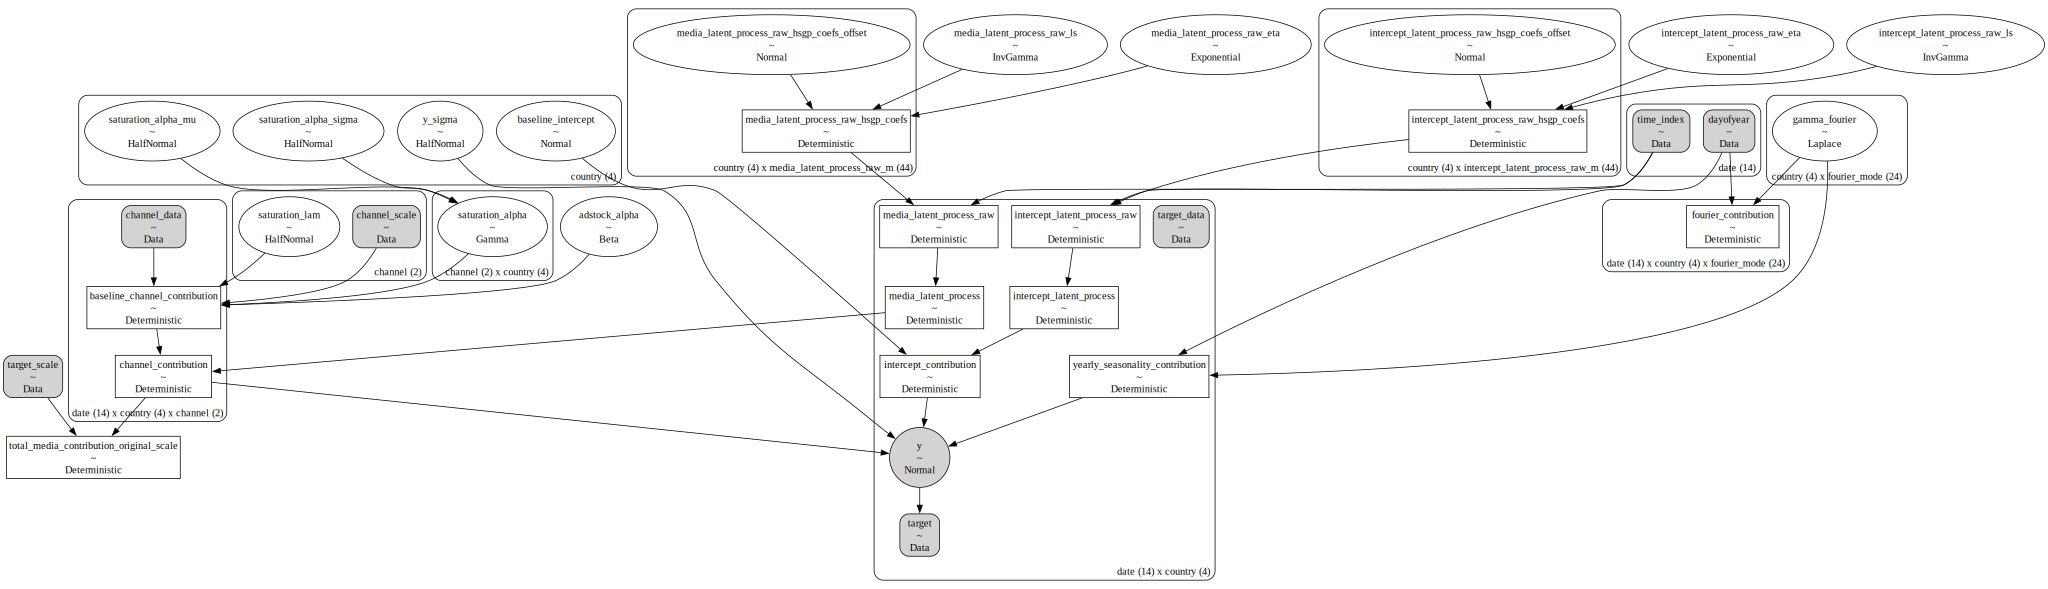

In [40]:
pm.model_to_graphviz(mmm.model)

In [41]:
mmm.add_original_scale_contribution_variable(
    var=["intercept_contribution", "channel_contribution"]
)

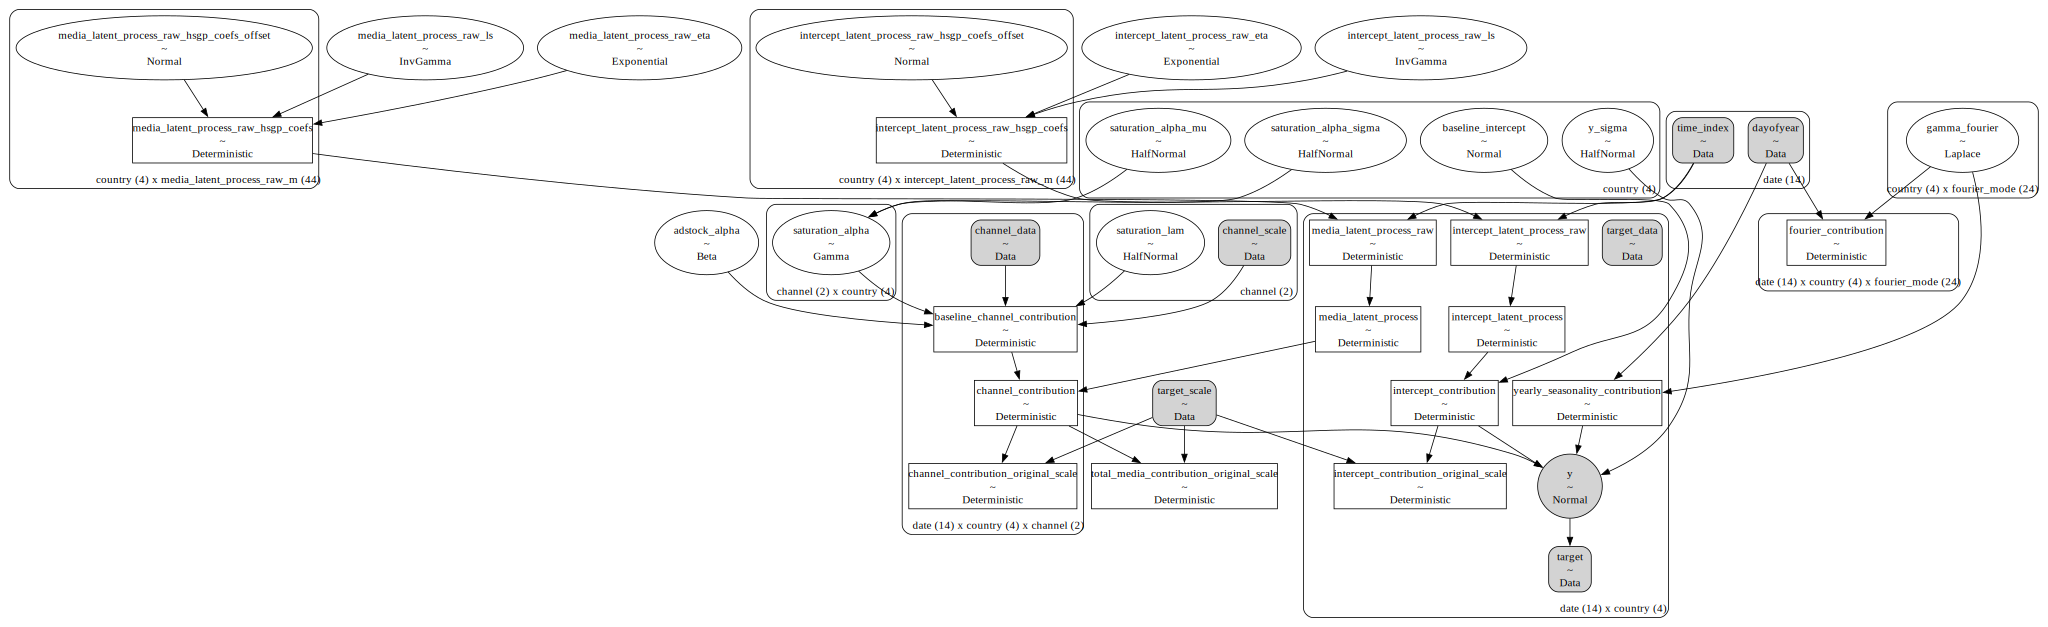

In [42]:
pm.model_to_graphviz(mmm.model)

In [43]:
pytensor.dprint(
    freeze_dims_and_data(mmm.model)["channel_contribution_original_scale"],
    depth=4,
    print_type=True,
)

Mul [id A] <Tensor3(float64, shape=(14, 4, 2))> 'channel_contribution_original_scale'
 ├─ Mul [id B] <Tensor3(float64, shape=(14, 4, 2))> 'channel_contribution'
 │  ├─ True_div [id C] <Tensor3(float64, shape=(14, 4, 2))> 'baseline_channel_contribution'
 │  │  ├─ Mul [id D] <Tensor3(float64, shape=(14, 4, 2))>
 │  │  └─ Add [id E] <Tensor3(float64, shape=(14, 4, 2))>
 │  └─ ExpandDims{axis=2} [id F] <Tensor3(float64, shape=(14, 4, 1))>
 │     └─ Add [id G] <Matrix(float64, shape=(14, 4))> 'media_latent_process'
 └─ ExpandDims{axes=[0, 1, 2]} [id H] <Tensor3(float64, shape=(1, 1, 1))>
    └─ target_scale{620.0177889132092} [id I] <Scalar(float64, shape=())>


In [44]:
mmm.fit(
    X=df_train.drop(columns="target"),
    y=df_train["target"],
    chains=4,
    target_accept=0.85,
    nuts_sampler="numpyro",
    random_seed=42,
)

mmm.sample_posterior_predictive(
    X=df_train.drop(columns="target"),
    extend_idata=True,
    combined=True,
    random_seed=42,
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y]


Output()

<xarray.Dataset> Size: 2MB
Dimensions:  (date: 14, country: 4, sample: 4000)
Coordinates:
  * date     (date) datetime64[ns] 112B 2023-01-01 2023-01-02 ... 2023-01-14
  * country  (country) <U9 144B 'Argentina' 'Chile' 'Colombia' 'Venezuela'
  * sample   (sample) object 32kB MultiIndex
  * chain    (sample) int64 32kB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 32kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    y        (date, country, sample) float64 2MB -0.0009855 0.00221 ... 0.6838
Attributes:
    created_at:                 2025-02-25T19:55:47.258587+00:00
    arviz_version:              0.20.0
    inference_library:          pymc
    inference_library_version:  5.20.1

In [14]:
mmm.idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data
	> fit_data
	> posterior_predictive

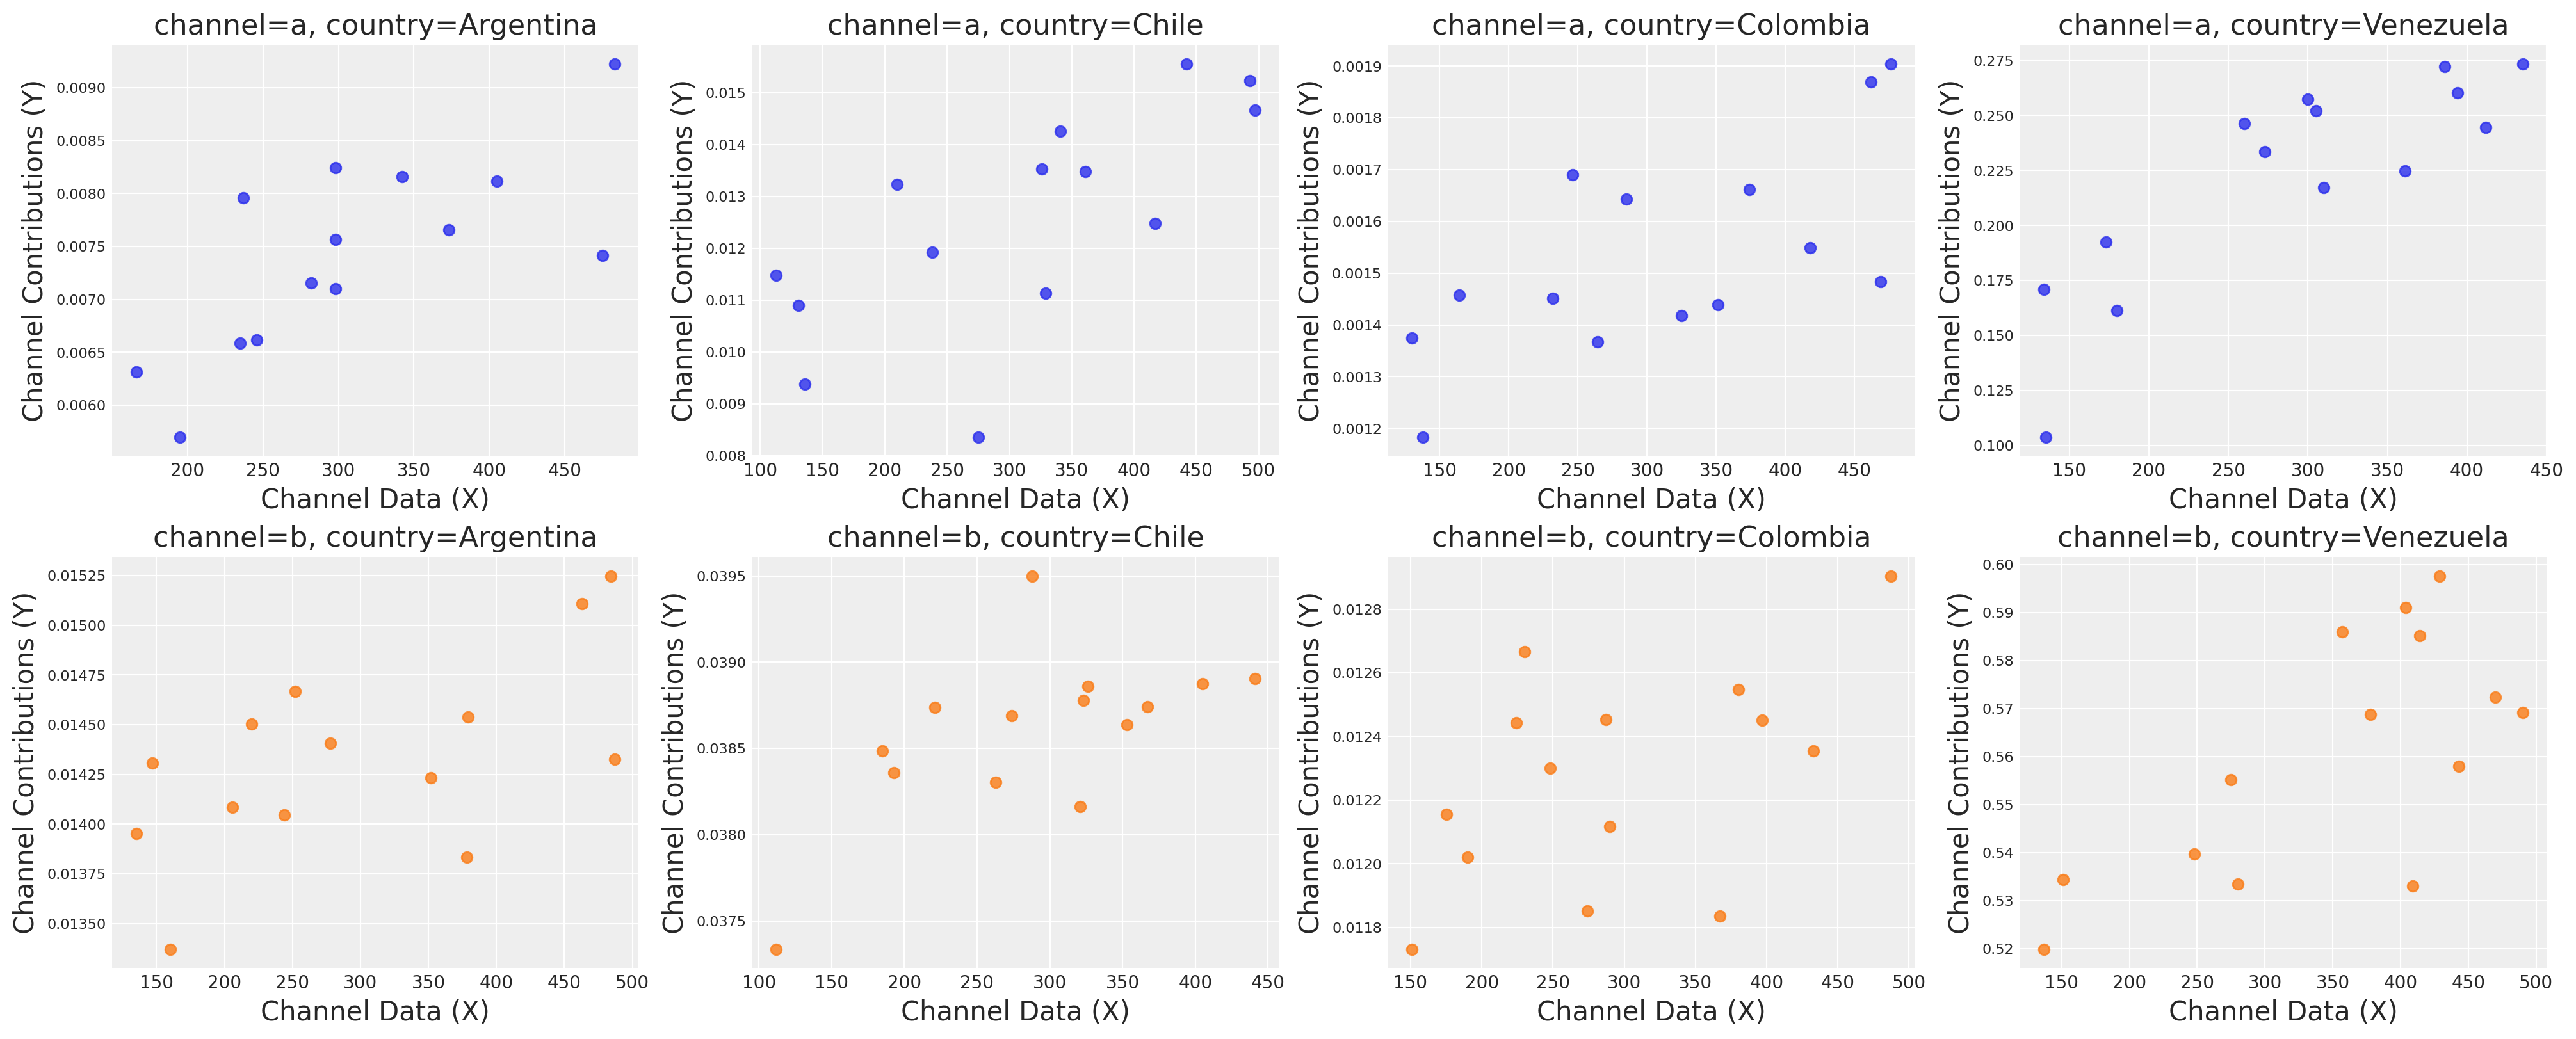

In [15]:
mmm.plot.saturation_curves_scatter();

In [16]:
_y_in_sample = mmm.sample_posterior_predictive(
    X=df_train.drop(columns="target"),
    extend_idata=False,
    include_last_observations=False,
    random_seed=42,
    var_names=["channel_contribution", "intercept_contribution"],
)

Sampling: []


Output()

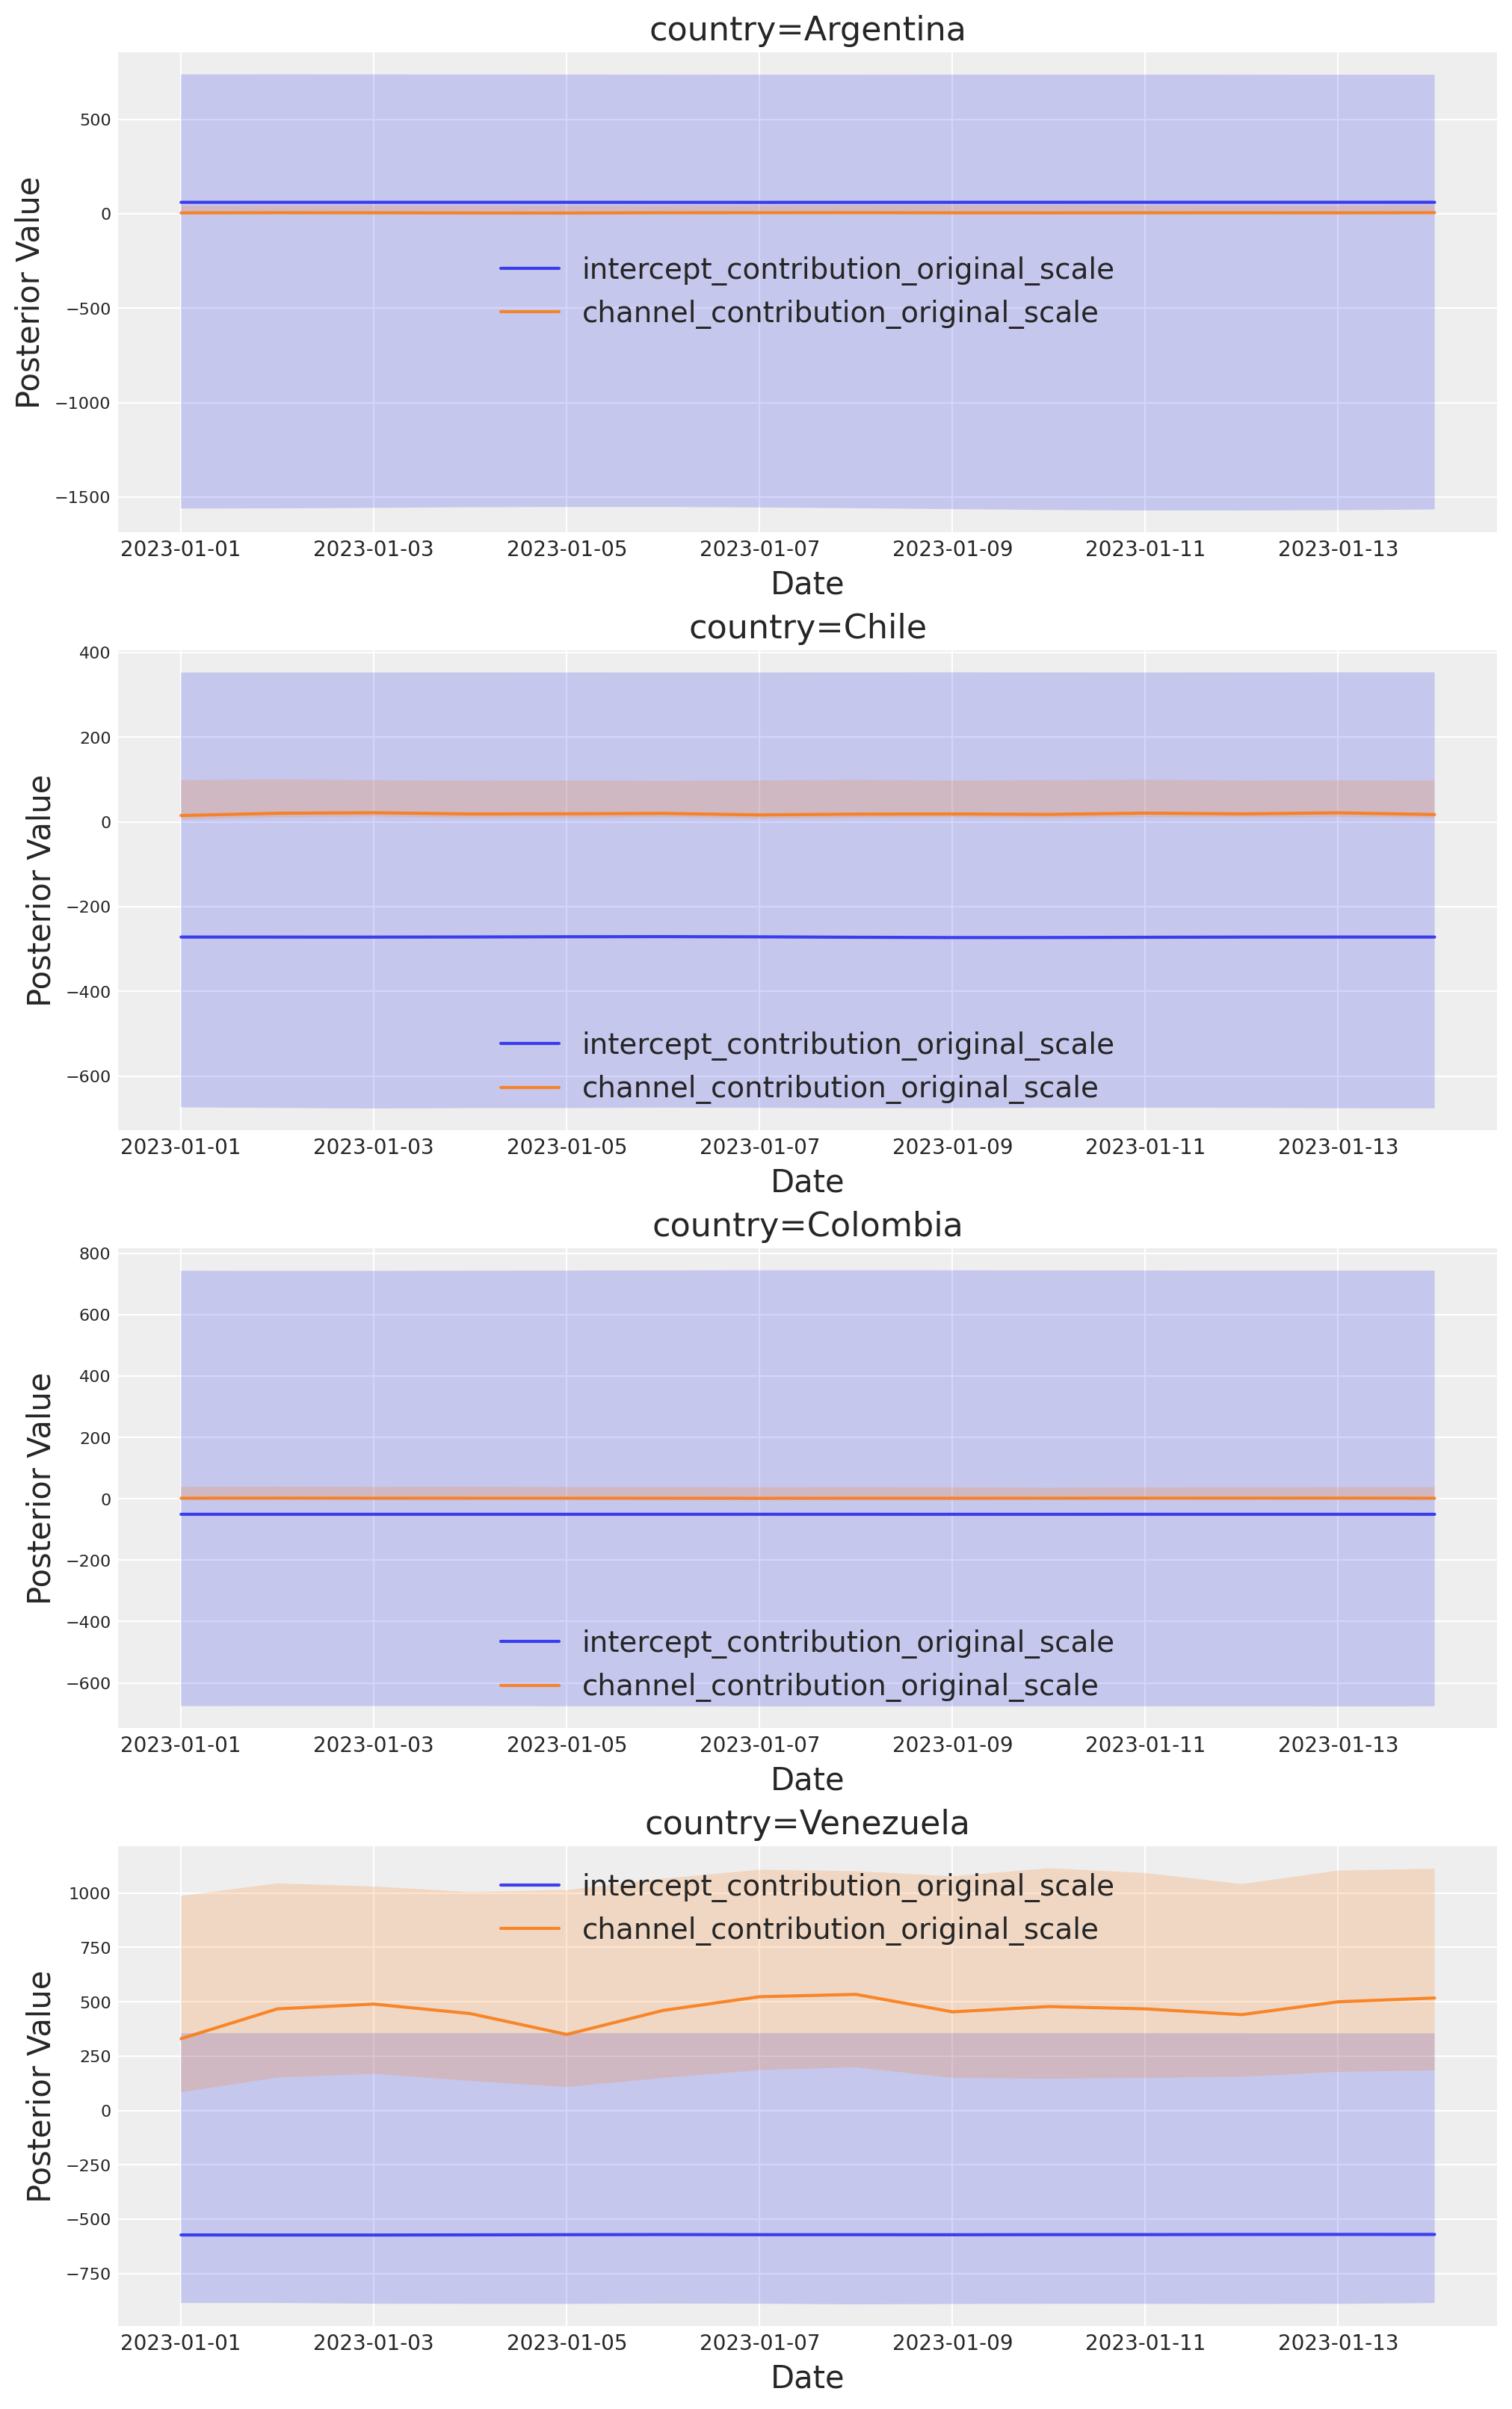

In [17]:
fig, ax = mmm.plot.contributions_over_time(
    var=[
        "intercept_contribution_original_scale",
        "channel_contribution_original_scale",
    ],
    ci=0.85,
)

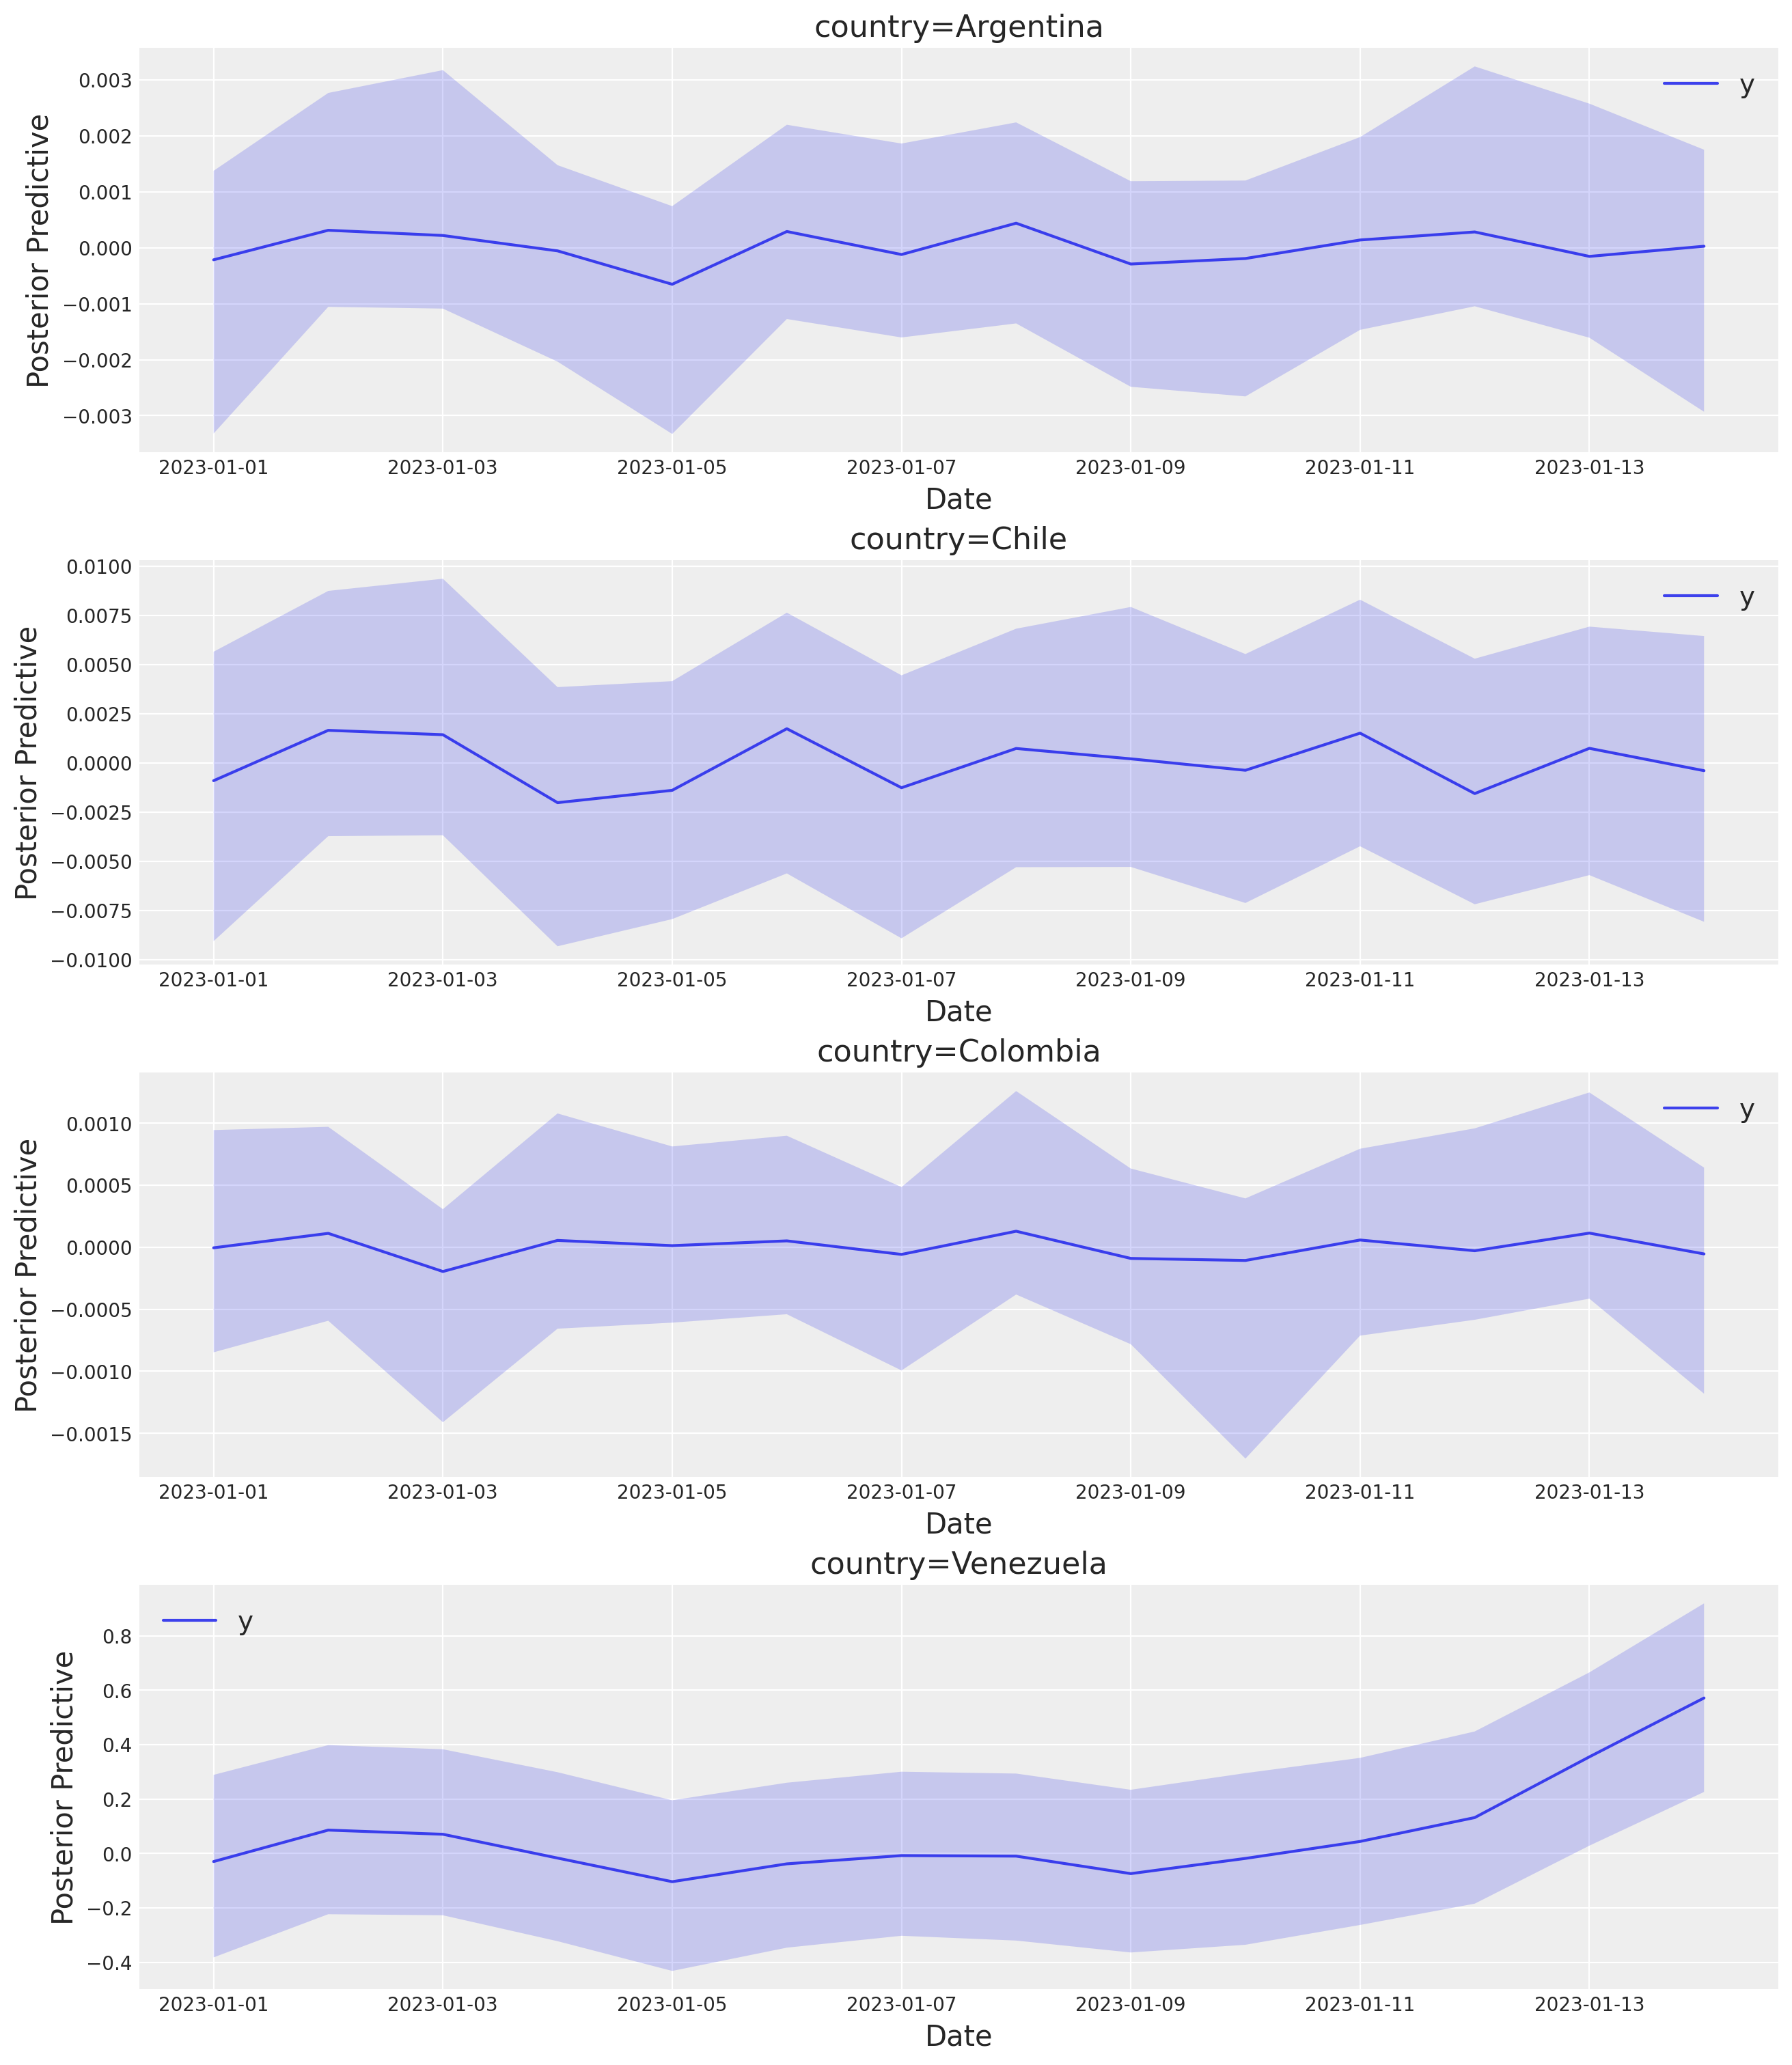

In [18]:
fig, ax = mmm.plot.posterior_predictive()
fig.set_size_inches(13, 15)

# Change the size of the axis letters to be smaller
for axis in ax.flatten():
    axis.tick_params(axis="both", which="major", labelsize=10)
    axis.tick_params(axis="both", which="minor", labelsize=8)

In [19]:
_y_out_sample = mmm.sample_posterior_predictive(
    X=df_test.drop(columns="target"),
    extend_idata=False,
    include_last_observations=True,
    combined=True,
    random_seed=42,
    var_names=["channel_contribution", "intercept_contribution"],
    clone_model=True,
)
_y_out_sample

Sampling: []


Output()

<xarray.Dataset> Size: 6MB
Dimensions:                 (date: 16, country: 4, channel: 2, sample: 4000)
Coordinates:
  * date                    (date) datetime64[ns] 128B 2023-01-15 ... 2023-01-30
  * country                 (country) <U9 144B 'Argentina' ... 'Venezuela'
  * channel                 (channel) <U1 8B 'a' 'b'
  * sample                  (sample) object 32kB MultiIndex
  * chain                   (sample) int64 32kB 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3
  * draw                    (sample) int64 32kB 0 1 2 3 4 ... 996 997 998 999
Data variables:
    channel_contribution    (date, country, channel, sample) float64 4MB 0.01...
    intercept_contribution  (date, country, sample) float64 2MB 0.1231 ... -0...
Attributes:
    created_at:                 2025-02-25T19:51:13.195109+00:00
    arviz_version:              0.20.0
    inference_library:          pymc
    inference_library_version:  5.20.1